In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def train_test_split(X, Y, test_size):
    
    shuffled_indices = np.random.permutation(len(X))

    test_set_size = int(len(X) * test_size)

    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    
    Y_train = Y[train_indices]
    Y_test = Y[test_indices]
    
    return X_train, X_test, Y_train, Y_test

In [3]:
def mean_squared_error(y_true, y_pred):
    y_pred = np.squeeze(y_pred)
    return np.mean((y_true - y_pred) ** 2)

### (1)MLR 

In [4]:
class MLR:
    def __init__(self):

        self.weights = None

    def fit(self, x, y):

        design_matrix = self.compute_design_matrix(x)

        design_matrix_dot_product = design_matrix.T @ design_matrix

        y_reshaped = y.reshape(-1, 1)

        self.weights = np.linalg.inv(design_matrix_dot_product) @ design_matrix.T @ y_reshaped # 3.15
        
        return self.weights

    def predict(self, x):

        design_matrix = self.compute_design_matrix(x)

        pred_mean = design_matrix.dot(self.weights)

        return pred_mean

    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        (3.16)
        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
        """
        n_samples = len(features)
        phi_0 = np.ones(n_samples).reshape(-1, 1)
        design_matrix = np.concatenate([phi_0, features], axis=1)
        return design_matrix

In [5]:
if __name__ == "__main__":
    calories = pd.read_csv(r".\calories.csv", index_col=0)
    exercise = pd.read_csv(r".\exercise.csv", index_col=0)

    features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp']

    mlr = MLR()

    x = exercise[features].values
    y = calories['Calories'].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125)

    mlr.fit(x = x_train, y = y_train)

    y_pred = mlr.predict(x = x_val)

    mse_val = mean_squared_error(y_val, y_pred)
    mse_test = mean_squared_error(y_test, mlr.predict(x = x_test))
    
    print(f"(MLR)Testing set's MSE : {mse_test}")

(MLR)Testing set's MSE : 128.50449744641833


### (2)BLR


In [6]:
class BLR:
    """ Bayesian linear regression
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """

    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis]  # column vector of shape (d, 1)
        self.prior_cov = prior_cov  # matrix of shape (d, d)
        
        # We also know the variance of the noise
        self.noise_var = noise_var  # single float value
        self.noise_precision = 1 / noise_var

        # Before performing any inference the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean  # corresponds to m_N in formulas
        self.post_cov = self.prior_cov  # corresponds to S_N in formulas

    def fit(self, x: np.ndarray, y: np.ndarray):
        y = y[:, np.newaxis]

        # (3.51)
        design_matrix = self.compute_design_matrix(x)

        design_matrix_dot_product = design_matrix.T @ design_matrix
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(inv_prior_cov + self.noise_precision * design_matrix_dot_product)  # Eq. (3.51) S_N

        # (3.50)
        self.post_mean = self.post_cov @ (inv_prior_cov @ self.prior_mean + self.noise_precision * design_matrix.T @ y) # m_N
        
        return self.post_mean, self.post_cov
    
    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        n_samples = len(features)
        phi_0 = np.ones(n_samples).reshape(-1, 1)
        design_matrix = np.concatenate([phi_0, features], axis=1)
        return design_matrix

    def predict(self, x: np.ndarray):
        design_matrix = self.compute_design_matrix(x)

        pred_mean = design_matrix.dot(self.post_mean)

        return pred_mean

In [7]:
if __name__ == "__main__":
    calories = pd.read_csv(r".\calories.csv", index_col=0)
    exercise = pd.read_csv(r".\exercise.csv", index_col=0)

    features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp']
    
    prior_mean = np.zeros(len(features) + 1)
    prior_cov = 1 * np.identity(len(features) + 1)
    noise_var = 0.001
    
    blr = BLR(prior_mean, prior_cov, noise_var)

    x = exercise[features].values
    y = calories['Calories'].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125)

    blr.fit(x = x_train, y = y_train)

    y_pred = blr.predict(x = x_val)

    mse_val = mean_squared_error(y_val, y_pred)
    mse_test = mean_squared_error(y_test, blr.predict(x = x_test))

    print(f"(BLR)Testing set's MSE : {mse_test}")

    print("")

(BLR)Testing set's MSE : 123.45793613810334



### (3) the difference between Maximum Likelihood and Bayesian Linear Regression

In [8]:
# 測試訓練集數量與MSE之間的關係
if __name__ == "__main__":
    calories = pd.read_csv(r".\calories.csv", index_col=0)
    exercise = pd.read_csv(r".\exercise.csv", index_col=0)

#     features = ['Duration']
    features = ['Age','Height','Weight','Duration','Heart_Rate','Body_Temp']
    
    prior_mean = np.zeros(len(features) + 1)
    prior_cov = 1 * np.identity(len(features) + 1)
    noise_var = 0.001
    
    mlr = MLR()
    blr = BLR(prior_mean, prior_cov, noise_var)

    x = exercise[features].values
    y = calories['Calories'].values
    
    N = 10000
    shuffled_indices = [i for i in range(len(x))]

    train_indices = shuffled_indices[:N]
    test_indices = shuffled_indices[N:]

    x_train = x[train_indices]
    x_test = x[test_indices]
    
    y_train = y[train_indices]
    y_test = y[test_indices]

    mlr.fit(x = x_train, y = y_train)
    Mn, Sn = blr.fit(x = x_train, y = y_train)
    
    print(f"(MLR)Testing set's MSE : {mean_squared_error(y_test, mlr.predict(x = x_test)) : .4f}")
    print(f"(BLR)Testing set's MSE : {mean_squared_error(y_test, blr.predict(x = x_test)) : .4f}")

    print("")

(MLR)Testing set's MSE :  131.2903
(BLR)Testing set's MSE :  131.2886



(MLR)Testing set's MSE :  348.1703
(BLR)Testing set's MSE :  348.1634



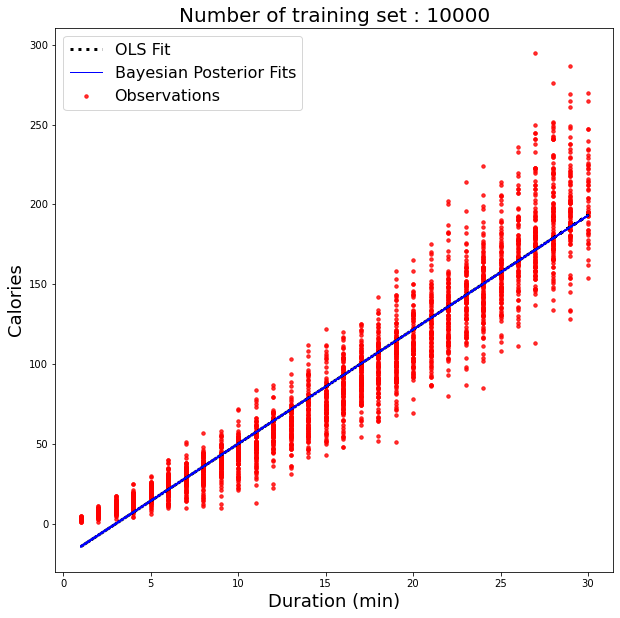

In [9]:
if __name__ == "__main__":
    calories = pd.read_csv(r".\calories.csv", index_col=0)
    exercise = pd.read_csv(r".\exercise.csv", index_col=0)

    features = ['Duration']
    
    prior_mean = np.zeros(len(features) + 1)
    prior_cov = 20 * np.identity(len(features) + 1)
    noise_var = 100

    mlr = MLR()
    
    blr = BLR(prior_mean, prior_cov, noise_var)

    x = exercise[features].values
    y = calories['Calories'].values
    
    N = 10000
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125)

    Mn, Sn = blr.fit(x = x_train[1:N,:], y = y_train[1:N])
    w = mlr.fit(x = x_train, y = y_train)
    
    print(f"(MLR)Testing set's MSE : {mean_squared_error(y_test, mlr.predict(x = x_test)) : .4f}")
    print(f"(BLR)Testing set's MSE : {mean_squared_error(y_test, blr.predict(x = x_test)) : .4f}")

    print("")
    
    f_xy = np.random.multivariate_normal(Mn.flatten(), Sn, 20)

    plt.figure(figsize = (10, 10))
    plt.scatter(x_test, y_test, s = 12, alpha = 0.8, c = 'r', label = 'Observations')
    plt.plot(x_test, w[0] + x_test * w[1], 'k:', label = 'OLS Fit', linewidth = 3)
    plt.plot(x_test, f_xy[0,0] + x_test * f_xy[0,1], 'b', label = 'Bayesian Posterior Fits', linewidth = 1)
    for i in range(1,len(f_xy)):
        plt.plot(x_test, f_xy[i,0] + x_test * f_xy[i,1], 'b', alpha = 0.5, linewidth = 1)
    plt.title(f'Number of training set : {N}', size = 20); 
    plt.xlabel('Duration (min)', size = 18);
    plt.ylabel('Calories', size = 18);
    plt.legend(prop={'size': 16});

### (4)best model

In [10]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

calories = pd.read_csv(r".\calories.csv", index_col=0)
exercise = pd.read_csv(r".\exercise.csv", index_col=0)

y = calories.values

le = LabelEncoder()
exercise['Gender'] = le.fit_transform(exercise['Gender'])

x = exercise.values

random_seed = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125)

model = LGBMRegressor(boosting_type='gbdt', random_state=random_seed,
                      n_estimators=3000, objective='regression', n_jobs=-1)

callbacks = [early_stopping(stopping_rounds=10), log_evaluation(period=10)]

eval_set = [(x_val, y_val)]

model.fit(x_train, y_train, eval_set=eval_set, callbacks=callbacks, eval_metric=['l2'])

y_pred = model.predict(x_val)

mse_val = mean_squared_error(np.squeeze(y_val), y_pred)
mse_test = mean_squared_error(np.squeeze(y_test), model.predict(x_test))

print("")
print(f"(lightgbm)Testing set's MSE : {mse_test}")

Training until validation scores don't improve for 10 rounds
[10]	valid_0's l2: 532.517
[20]	valid_0's l2: 96.4396
[30]	valid_0's l2: 27.0248
[40]	valid_0's l2: 12.6715
[50]	valid_0's l2: 8.1198
[60]	valid_0's l2: 6.34874
[70]	valid_0's l2: 5.4215
[80]	valid_0's l2: 4.91969
[90]	valid_0's l2: 4.51011
[100]	valid_0's l2: 4.17364
[110]	valid_0's l2: 3.86967
[120]	valid_0's l2: 3.61384
[130]	valid_0's l2: 3.44975
[140]	valid_0's l2: 3.29311
[150]	valid_0's l2: 3.18573
[160]	valid_0's l2: 3.0802
[170]	valid_0's l2: 2.95967
[180]	valid_0's l2: 2.87709
[190]	valid_0's l2: 2.80134
[200]	valid_0's l2: 2.73854
[210]	valid_0's l2: 2.69004
[220]	valid_0's l2: 2.65178
[230]	valid_0's l2: 2.61656
[240]	valid_0's l2: 2.54363
[250]	valid_0's l2: 2.51341
[260]	valid_0's l2: 2.46497
[270]	valid_0's l2: 2.41977
[280]	valid_0's l2: 2.37007
[290]	valid_0's l2: 2.31578
[300]	valid_0's l2: 2.29868
[310]	valid_0's l2: 2.25195
[320]	valid_0's l2: 2.22235
[330]	valid_0's l2: 2.2122
[340]	valid_0's l2: 2.19558
